In [1]:
import logging
import os
import torch
from torch.utils.data import DataLoader
from drcnet.fit import fit_model
from drcnet.model import DenoiserNet
from utils import setup_logging
from utils.data import DBrainDataLoader, StanfordDataLoader
from utils.metrics import visualize_single_volume
from utils.utils import load_config

train = False
dataset = "dbrain"
# Setup logging
log_file = setup_logging(log_level=logging.INFO)
logging.info(f"Starting training with dataset: {dataset}")

# Get the directory where this script is located
script_dir = "/home/paco/TechJourney/TechJourney/DWMRI/src/drcnet"
config_path = os.path.join(script_dir, "config.yaml")

logging.info(f"Loading config from: {config_path}")

settings = load_config(config_path)
logging.info("Configuration loaded successfully")

if dataset == "dbrain":
    logging.info("Using DBrain dataset configuration")
    settings = settings.dbrain
    data_loader = DBrainDataLoader(
        nii_path=settings.data.nii_path,
        bvecs_path=settings.data.bvecs_path,
        bvalue=settings.data.bvalue,
        noise_sigma=settings.data.noise_sigma,
    )
original_data, noisy_data = data_loader.load_data()
take_volumes = settings.data.num_b0s + settings.data.num_volumes
logging.info(
    f"Taking volumes from {settings.data.num_b0s} to {take_volumes}"
)
noisy_data = noisy_data[
    : settings.data.take_x,
    : settings.data.take_y,
    : settings.data.take_z,
    settings.data.num_b0s : take_volumes,
]


/home/paco/vqvae/env-torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-03 16:16:13,977 - root - INFO - Logging configured - level: INFO, file: logs/training_20250803_161613.log
2025-08-03 16:16:13,978 - root - INFO - Starting training with dataset: dbrain
2025-08-03 16:16:13,979 - root - INFO - Loading config from: /home/paco/TechJourney/TechJourney/DWMRI/src/drcnet/config.yaml
2025-08-03 16:16:13,980 - root - INFO - Loading configuration from: /home/paco/TechJourney/TechJourney/DWMRI/src/drcnet/config.yaml
2025-08-03 16:16:13,985 - root - INFO - Configuration file loaded successfully
2025-08-03 16:16:13,986 - root - INFO - Configuration converted to Munch object
2025-08-03 16:16:13,986 - root - INFO - Configuration loaded successfully
2025-08-03 16:16:13,987 - root - INFO - Using DBrain dat

(96, 10, 128, 128)


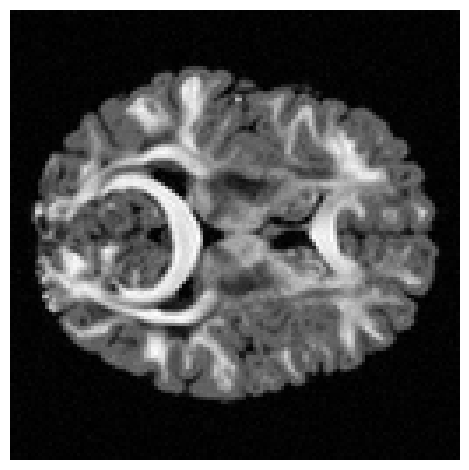

In [2]:
import numpy as np

visualize_single_volume(
                np.transpose(noisy_data, (2,3,0,1)),
            )

In [3]:
# setting checkpoint dir taking into account run/model parameters
checkpoint_dir = os.path.join(
    settings.train.checkpoint_dir,
    f"bvalue_{settings.data.bvalue}",
    f"num_volumes_{settings.data.num_volumes}",
    f"noise_sigma_{settings.data.noise_sigma}",
    f"learning_rate_{settings.train.learning_rate}",
)
os.makedirs(checkpoint_dir, exist_ok=True)


In [4]:
import logging
import os

import numpy as np
import torch
from drcnet.data import ReconstructionDataSet, TrainingDataSet
from drcnet.fit import fit_model
from drcnet.model import DenoiserNet
from drcnet.reconstruction import reconstruct_dwis
from torch.utils.data import DataLoader
from utils import setup_logging
from utils.checkpoint import load_checkpoint
from utils.data import DBrainDataLoader, StanfordDataLoader
from utils.metrics import (
    compare_volumes,
    compute_metrics,
    save_metrics,
    visualize_single_volume,
)
from utils.utils import load_config

logging.info("Reconstructing DWIs...")
best_loss_checkpoint = os.path.join(
    checkpoint_dir, "best_loss_checkpoint.pth"
)
reconstruct_model = DenoiserNet(
    input_channels=settings.model.in_channel,
    output_channels=settings.model.out_channel,
    groups=settings.model.groups,
    dense_convs=settings.model.dense_convs,
    residual=settings.model.residual,
    base_filters=settings.model.base_filters,
    output_shape=(
        settings.model.out_channel,
        settings.data.take_x,
        settings.data.take_y,
        settings.data.take_z,
    ),
    device=settings.train.device,
)
reconstruct_model, _, _, _, _ = load_checkpoint(
    model=reconstruct_model,
    optimizer=None,
    filename=best_loss_checkpoint,
    device=settings.reconstruct.device,
)
reconstruct_set = ReconstructionDataSet(noisy_data)
reconstruct_loader = DataLoader(
    reconstruct_set, batch_size=1, shuffle=False
)
reconstructed_dwis = reconstruct_dwis(
    model=reconstruct_model,
    data_loader=reconstruct_loader,
    device=settings.reconstruct.device,
)
logging.info(f"Reconstructed DWIs shape: {reconstructed_dwis.shape}")
logging.info(
    f"Reconstructed DWIs min: {reconstructed_dwis.min():.4f}, "
    f"max: {reconstructed_dwis.max():.4f}, "
    f"mean: {reconstructed_dwis.mean():.4f}"
)


2025-08-03 16:16:26,737 - root - INFO - Reconstructing DWIs...
2025-08-03 16:16:26,738 - root - INFO - Initializing DenoiserNet: input_channels=9, output_channels=1, groups=1, dense_convs=2, residual=True, base_filters=32
2025-08-03 16:16:26,760 - root - INFO - Initializing GatedBlock: x_channels=32, h_channels=32, dense_convs=2, groups=1
2025-08-03 16:16:26,760 - root - INFO - Initializing DenoisingBlock: in_channels=64, inner_channels=32, out_channels=32, inner_convolutions=2, residual=False
2025-08-03 16:16:26,761 - root - INFO - Initializing FactorizedBlock: in_channels=96, out_channels=32, groups=1
2025-08-03 16:16:26,763 - root - INFO - Initializing FactorizedBlock: in_channels=128, out_channels=32, groups=1
2025-08-03 16:16:26,956 - root - INFO - Attempting to load checkpoint from: drcnet/checkpoints/dbrain/bvalue_2500/num_volumes_10/noise_sigma_0.01/learning_rate_1e-05/best_loss_checkpoint.pth
2025-08-03 16:16:26,997 - root - ERROR - Failed to load checkpoint: 'NoneType' object

In [5]:
reconstructed_dwis.shape

(10, 128, 128, 96)

(96, 10, 128, 128)


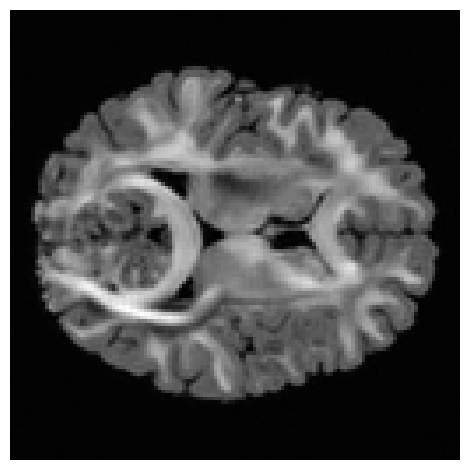

(96, 10, 128, 128)


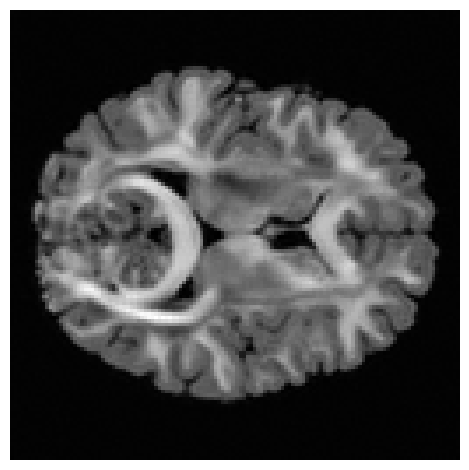

(96, 10, 128, 128)


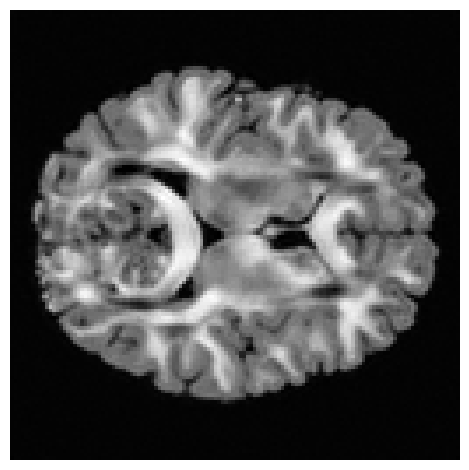

(96, 10, 128, 128)


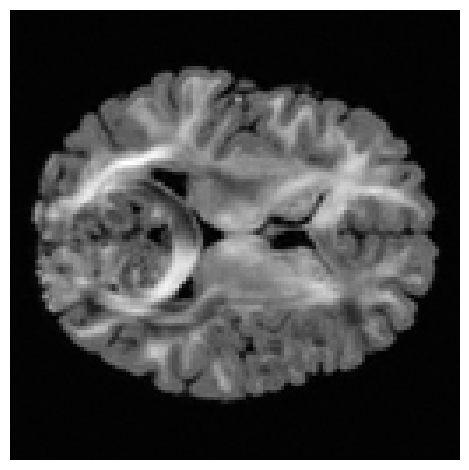

(96, 10, 128, 128)


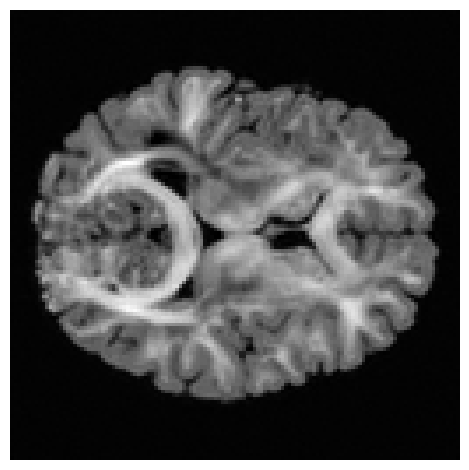

(96, 10, 128, 128)


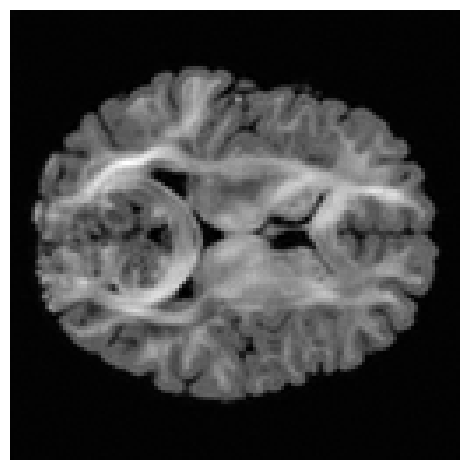

(96, 10, 128, 128)


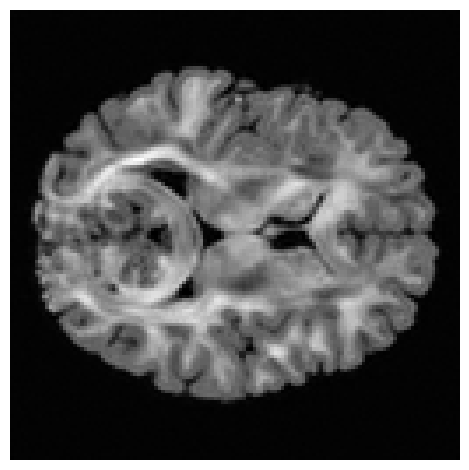

(96, 10, 128, 128)


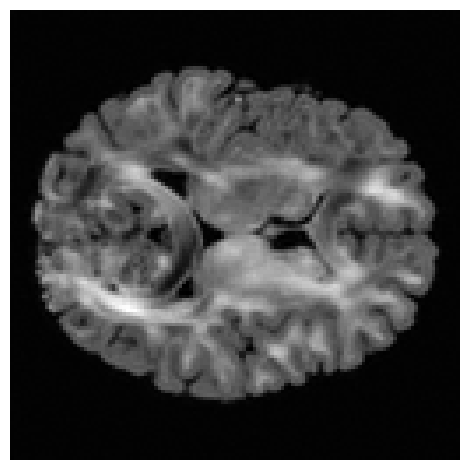

(96, 10, 128, 128)


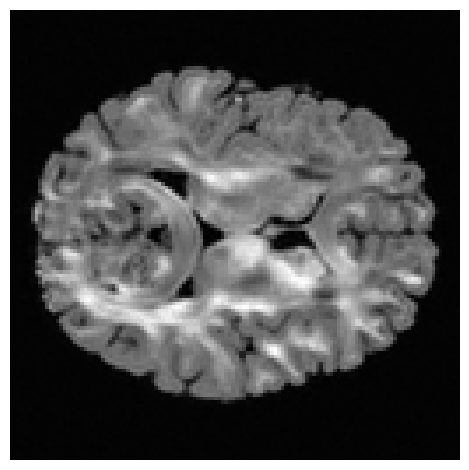

(96, 10, 128, 128)


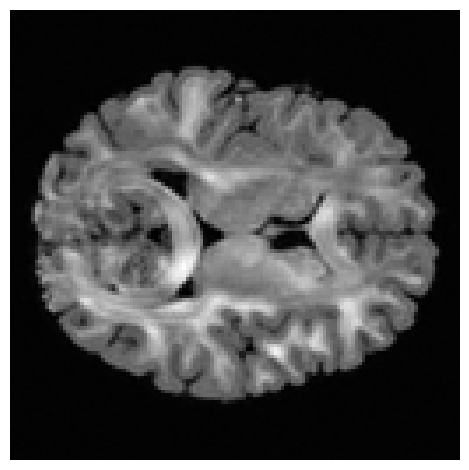

In [6]:
for i in range(10):
    visualize_single_volume(
                np.transpose(reconstructed_dwis, (3, 0, 1, 2)),
    volume_idx=i
            )

(96, 10, 128, 128)


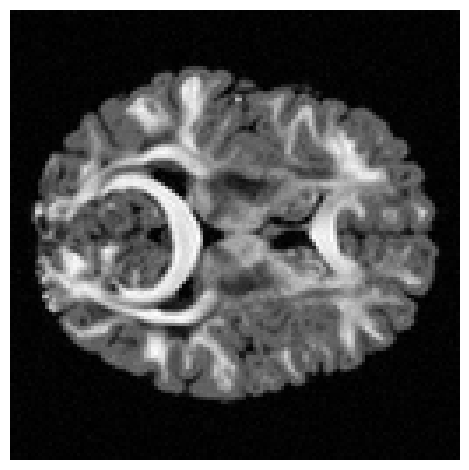

(96, 10, 128, 128)


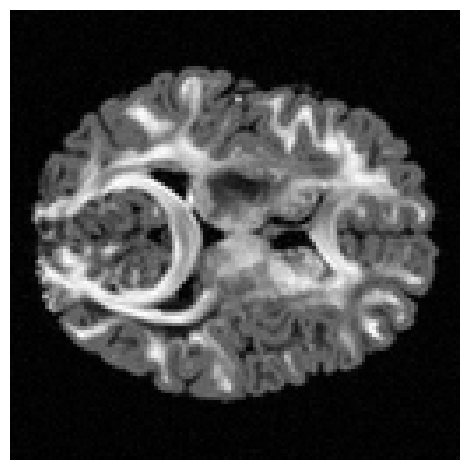

(96, 10, 128, 128)


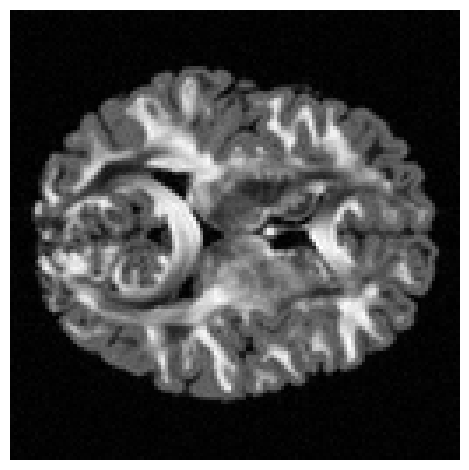

(96, 10, 128, 128)


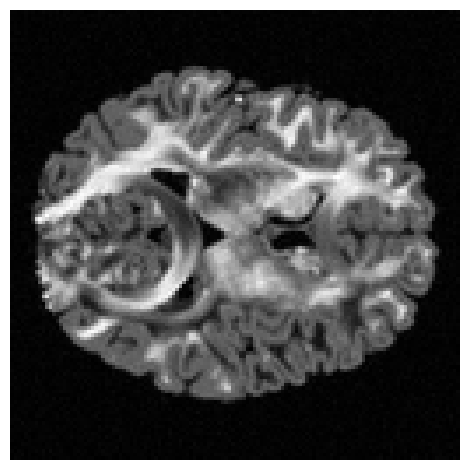

(96, 10, 128, 128)


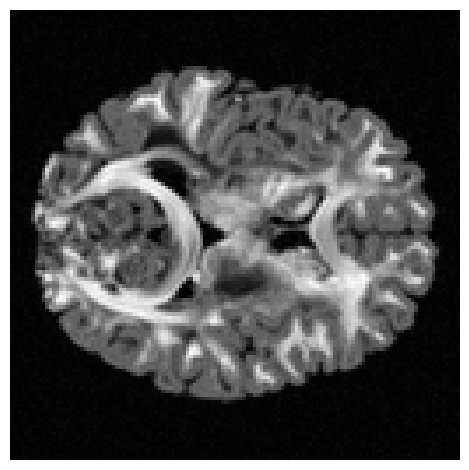

(96, 10, 128, 128)


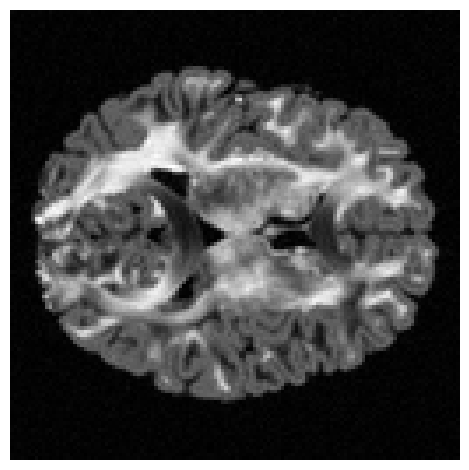

(96, 10, 128, 128)


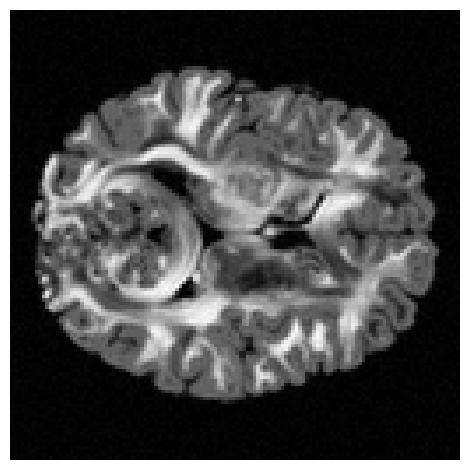

(96, 10, 128, 128)


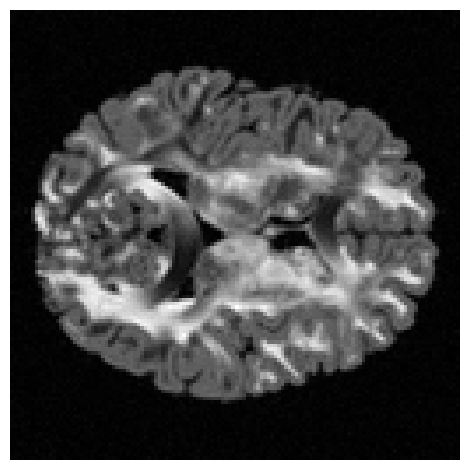

(96, 10, 128, 128)


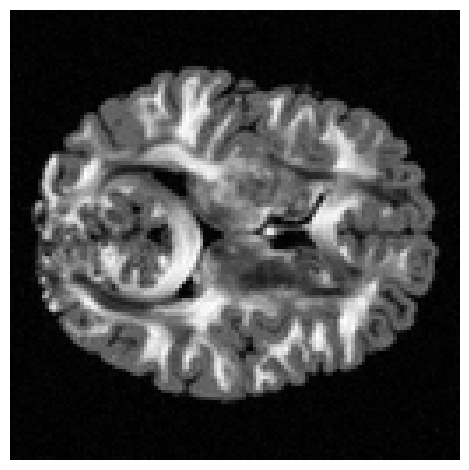

(96, 10, 128, 128)


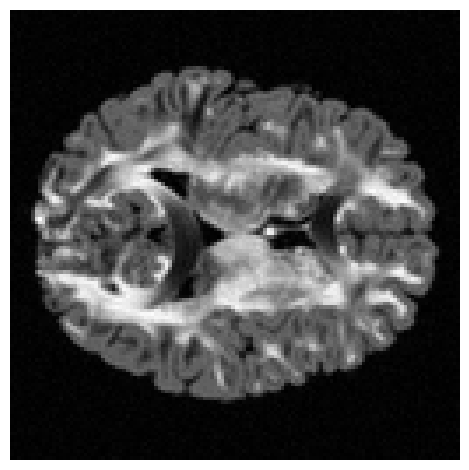

In [7]:
for i in range(10):
    visualize_single_volume(
                np.transpose(noisy_data, (2,3,0,1)),
    volume_idx=i
            )

In [8]:
reconstruct_loader = DataLoader(
    reconstruct_set, batch_size=4, shuffle=False
)

In [14]:
import logging

import numpy as np
import torch
from tqdm import tqdm


def reconstruct_dwis(model, data_loader, device):
    logging.info(f"Starting DWI reconstruction on device: {device}")
    model.to(device)
    model.eval()
    reconstructed_dwis = []
    with torch.inference_mode():
        for x, _ in tqdm(data_loader, desc="Reconstructing"):
            logging.info("x shape %s", x.shape)
            x = x.to(device)
            means = x.mean(dim=1, keepdim=True)
            logging.info("means shape %s", means.shape)
            reconstructed = model(x)
            reconstructed_dwis.append(
                reconstructed.squeeze().detach().cpu().numpy()
            )
    logging.info("DWI reconstruction completed.")
    return np.array(reconstructed_dwis)


In [15]:
reconstruct_dwis(
    model=reconstruct_model,
    data_loader=reconstruct_loader,
    device=settings.reconstruct.device,
)

2025-08-03 16:29:43,663 - root - INFO - Starting DWI reconstruction on device: cuda
2025-08-03 16:29:43,836 - root - INFO - x shape torch.Size([4, 9, 128, 128, 96])
2025-08-03 16:29:43,864 - root - INFO - means shape torch.Size([4, 1, 128, 128, 96])
Reconstructing:   0%|          | 0/3 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 768.00 MiB. GPU 0 has a total capacity of 10.75 GiB of which 232.75 MiB is free. Process 1882649 has 282.00 MiB memory in use. Process 101422 has 3.13 GiB memory in use. Process 100618 has 4.80 GiB memory in use. Including non-PyTorch memory, this process has 2.31 GiB memory in use. Of the allocated memory 1.88 GiB is allocated by PyTorch, and 257.57 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)